# Sentiment Analysis of Tweets directed at Brands and Products

## 1.0 Business Understanding

In today’s digital age, customers frequently share their opinions about products and brands on social media platforms like Twitter. These opinions provide valuable insights for companies to understand customer satisfaction, detect dissatisfaction early, and improve their products or services.

The business problem is to automatically identify the sentiment expressed in tweets about Apple and Google products. By classifying tweets as positive, negative, or neutral, businesses can:

1. Monitor brand reputation in real time.

2. Track how customers respond to new product releases or updates.

3. Identify areas for improvement based on negative feedback.

4. Support data-driven decision-making in marketing and product strategy.

The ultimate goal is to build a sentiment analysis model that helps businesses quickly interpret large volumes of customer feedback without manual review.

## 2.0 Data Understanding

The dataset comes from CrowdFlower and contains over 9,000 tweets related to Apple and Google products. Each tweet has been human-labeled for sentiment as:

1. Positive emotion

2. Negative emotion

3. No emotion toward brand/product

4. Unclear/I can’t tell

##### Key characteristics:

* Textual Data: Tweets are short, noisy, and often contain slang, hashtags, mentions, and URLs, which makes preprocessing crucial.

* Target Variable: The label indicating whether a sentiment is directed at a brand or product.

* Class Distribution: The dataset is slightly imbalanced, with more neutral/no-emotion tweets compared to positive or negative ones.

This dataset is well-suited for the business problem because it directly reflects real customer opinions on social media about Apple and Google. The labeled sentiments provide a foundation for training supervised machine learning models to classify unseen tweets in real time.

In [64]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
# NLTK downloads
nltk.download('punkt')       #  Downloads the Punkt tokenizer models used for sentence splitting and word tokenization
nltk.download('stopwords')   #  Downloads the list of common stopwords (like "is", "the", "and") in multiple languages
nltk.download('wordnet')     #  Downloads the WordNet lexical database used for lemmatization and word meaning
nltk.download('omw-1.4')     #  Downloads Open Multilingual WordNet, which extends WordNet to multiple languages


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 3.0 Exploratory Data Analysis

In [50]:
# Loading dataset

df = pd.read_csv("Data\judge-1377884607_tweet_product_company.csv",encoding="latin1")

# Quick overview
print(df.shape)
print("\n")
df.info()
print("\n")
df.head()


(9093, 3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB




,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset has 9093 rows and 3 columns.

Key columns of interest:

* tweet_text → raw tweet ( The input feature)

* is_there_an_emotion_directed_at_a_brand_or_product → target sentiment

* emotion_in_tweet_is_directed_at → optional metadata (brand/product mentioned)

In [51]:
# Checks for Missing Values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

tweet_text: 1 missing value

emotion_in_tweet_is_directed_at: ~5,800 missing (not essential for sentiment task)

is_there_an_emotion_directed_at_a_brand_or_product: no missing values

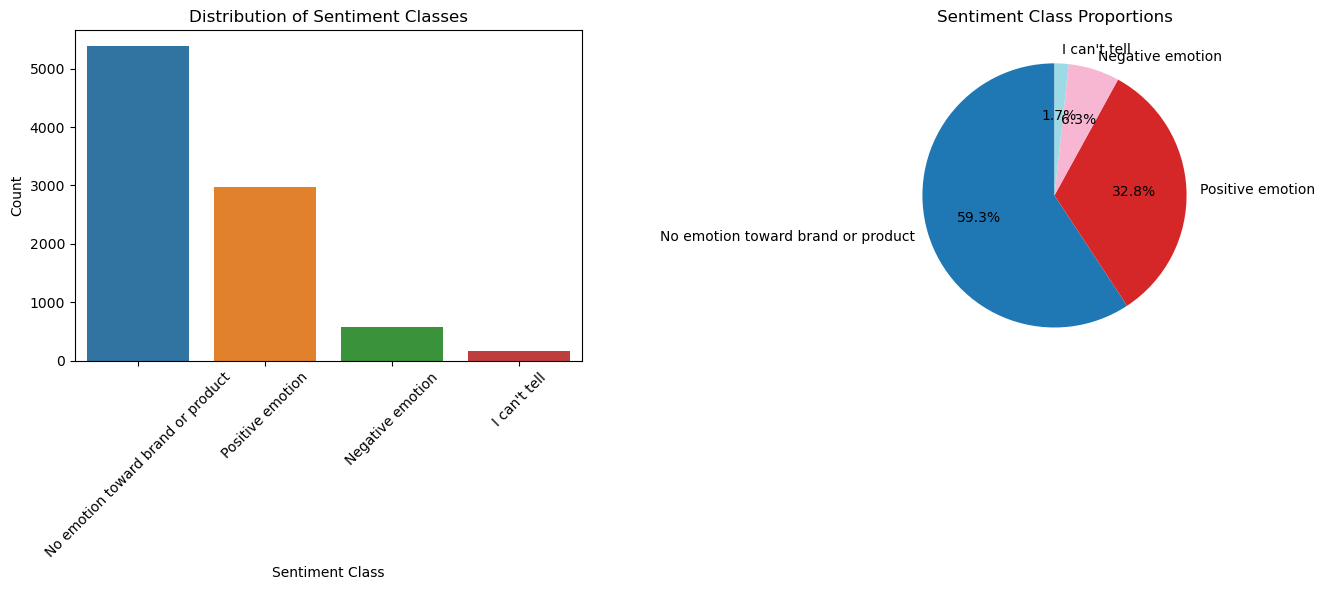

In [52]:
# Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # one row, two columns

# --- Countplot on the left ---
sns.countplot(
    x=df['is_there_an_emotion_directed_at_a_brand_or_product'],
    order=df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().index,
    ax=axes[0]
)
axes[0].set_title("Distribution of Sentiment Classes")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_xlabel("Sentiment Class")
axes[0].set_ylabel("Count")

# --- Pie chart on the right ---
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', ax=axes[1], startangle=90, cmap='tab20'
)
axes[1].set_ylabel("")  # remove y-label
axes[1].set_title("Sentiment Class Proportions")

plt.tight_layout()
plt.show()

The dataset contains four target categories: Positive emotion, Negative emotion, No emotion toward brand or product, and I can’t tell. An imbalance is evident across these classes, with the No emotion category appearing more frequently than the Positive emotion category.

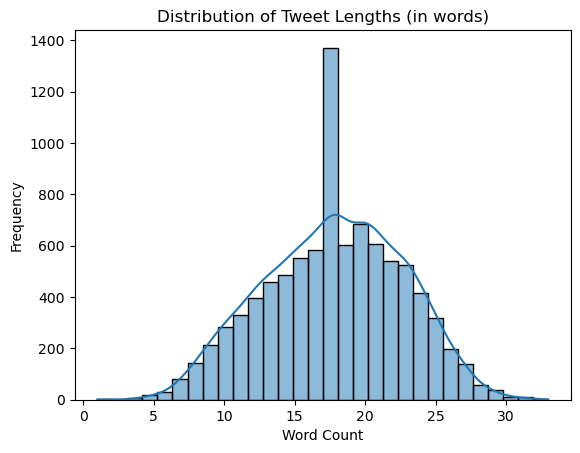

In [53]:
# Tweet Length Analysis
df['tweet_length'] = df['tweet_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths (in words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


Most tweets range between 5–25 words, with a few outliers that are either very short (1–2 words) or unusually long.

## 4.0  Data Preparation

In [54]:
# Handles Missing Values

# Drop rows with null tweets (main feature)
df = df.dropna(subset=['tweet_text'])

# Verify shape after dropping
print("Shape after dropping null tweet_text:", df.shape)

# Check target distribution
print("\nTarget value counts:")
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())


Shape after dropping null tweet_text: (9092, 4)

Target value counts:
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


Dataset Overview After Cleaning

After removing rows with missing tweet_text, the dataset contains 9,092 records.

The distribution of target labels indicates a noticeable class imbalance:

* No emotion toward brand or product: 5,388

* Positive emotion: 2,978

* Negative emotion: 570

* I can’t tell: 156

The No emotion category is the majority class, while Negative and I can’t tell are underrepresented

In [55]:
# Binary Classification Setup
# Keep only Positive and Negative emotions
df_binary = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion'])]

# Check new shape and distribution
print("Shape of binary dataset:", df_binary.shape)
print("\nBinary target distribution:")
print(df_binary['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())


Shape of binary dataset: (3548, 4)

Binary target distribution:
Positive emotion    2978
Negative emotion     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


For the binary classification task, only the Positive emotion and Negative emotion classes were retained, resulting in a dataset of 3,548 records, where Positive emotion (2,978) substantially outnumbers Negative emotion (570), indicating class imbalance.

## 5.0 NLP Pre-Processing

### 5.1 Text preprocessing 

Tweets contain noise such as URLs, hashtags, mentions, punctuation, numbers, and filler words (stopwords). If we feed this raw text directly into a model, it can mislead the classifier. Therefore, we clean and normalize the text so that the model focuses only on meaningful tokens.

In [56]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions & hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords + lemmatize
    return ' '.join(tokens)

# # Apply cleaning to tweets
# df['cleaned_tweet'] = df['tweet_text'].apply(clean_text)

# # Preview cleaned text
# df[['tweet_text', 'cleaned_tweet']].head()

# Binary dataset
df_binary = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(
    ['Positive emotion', 'Negative emotion']
)].copy()

df_binary['cleaned_tweet'] = df_binary['tweet_text'].apply(clean_text)




### 5.2  Encode Labels

Machine learning models work with numbers, not strings → we use Label Encoding to convert classes into integers.

In [57]:
label_encoder = LabelEncoder()
df_binary['label'] = label_encoder.fit_transform(
    df_binary['is_there_an_emotion_directed_at_a_brand_or_product']
)
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'Negative emotion': 0, 'Positive emotion': 1}


### 5.3 Train-Test Split

In [58]:

#  we test on 20% of the data, stratifying to maintain class balance

X = df_binary['cleaned_tweet']
y = df_binary['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# After split: check training distribution
print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

# After split: check testing distribution
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


Training set class distribution:
1    0.839323
0    0.160677
Name: label, dtype: float64

Test set class distribution:
1    0.839437
0    0.160563
Name: label, dtype: float64


## 6.0 Modelling and Evaluation

The TF-IDF Vectorizer (Term Frequency–Inverse Document Frequency) transforms text data into numerical features that reflect the importance of words in documents relative to a corpus. It helps highlight words that are more relevant to specific documents while down-weighting common words that appear frequently across all documents.

### 6.1 Baseline Model Benchmarking with Cross-Validation Pipeline

We build and compare multiple models, we then evaluate algorithms such as **Logistic Regression, Random Forest, Gradient Boosting, AdaBoost, and XGBoost**. This helps us benchmark performance and identify the best model for our dataset.

**The TF-IDF Vectorizer** (Term Frequency–Inverse Document Frequency) transforms text data into numerical features that reflect the importance of words in documents , It helps highlight words that are more relevant to specific documents while down-weighting common words that appear frequently across all documents.

**Cross-Validation:** Evaluates models consistently using 5-fold CV and accuracy scoring.

**smote** – Balances minority class by generating synthetic samples.



In [ ]:
#This step trains each model on multiclass sentiment labels using TF-IDF features, 
# applies SMOTE balancing, and prints cross-validation accuracy.

# Define models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier( eval_metric='mlogloss'),
}

# Function to train and evaluate with cross-validation
def evaluate_models(models, X_train, y_train):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))), #Convert raw text into numerical features using TF-IDF.
            ('smote', SMOTE(random_state=42)), #Balances minority class by generating synthetic samples.
            ('clf', model)
        ])
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
        results[name] = scores.mean()
        print(f"{name}: {scores.mean():.4f}")
    return results

results = evaluate_models(models, X_train, y_train)


Baseline: 0.1607
Naive Bayes: 0.7907
Logistic Regression: 0.8319
Random Forest: 0.8728
KNN: 0.3908
Gradient Boosting: 0.8206
AdaBoost: 0.7995
XGBoost: 0.8492


### 6.2 Pick Best Model and Retrain


In [60]:
# Pick the best model based on cross-validation accuracy and retrain it on the full training set
best_model_name = max(results, key=results.get)
print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]:.4f}") 


Best model: Random Forest with accuracy 0.8728


In [61]:
# refit the best model pipeline on training data  
# our best Model is Random Forest with accuracy 0.8724
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('smote', SMOTE(random_state=42)),  
    ('clf', models[best_model_name])])

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('smote', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier())])

### 6.3 Evaluate on Test Data
- this helps check the model before tuning it. its a tuning benchmark

----------------------------------------
Classification Reprt: 
               precision    recall  f1-score   support

           0       0.76      0.37      0.50       114
           1       0.89      0.98      0.93       596

    accuracy                           0.88       710
   macro avg       0.83      0.67      0.71       710
weighted avg       0.87      0.88      0.86       710

----------------------------------------
Accuracy:
 0.8802816901408451
----------------------------------------
Confusion Matrix:



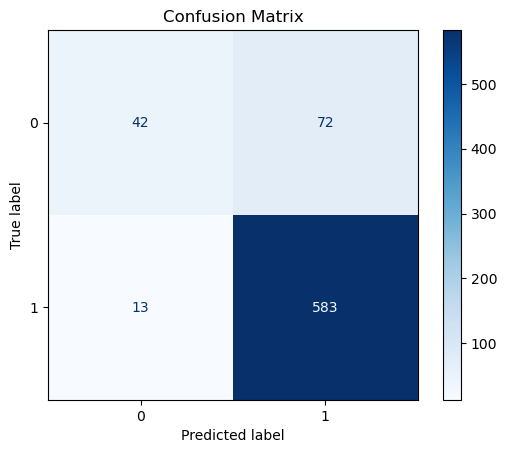

In [73]:
y_pred = best_pipeline.predict(X_test)

print("-"*40)
print( "Classification Reprt: \n",classification_report(y_test, y_pred))
print("-"*40)
print("Accuracy:\n", accuracy_score(y_test, y_pred))
print("-"*40)
print("Confusion Matrix:\n")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()